# Experiments on the use of the different estimated distributions in the 2D case with toy data, for classification purposes

In [1]:
run init.ipynb

Done.


#### Dataset Dev


In [13]:
dataset = DatasetGenerator(dataset_name=dataset_name, 
                                            num_samples=num_samples, 
                                            imbalance_ratio=imbalance_ratio, 
                                            missing_data_handling=missing_data_handling,
                                            imputation_method=imputation_method,
                                            verbosity=verbosity)

from sklearn import datasets
from sklearn.preprocessing import StandardScaler  
from sklearn.utils import shuffle


In [15]:
self=dataset
self.dataset_name='blobs'
num_samples_gt = 2000

################################
# Generate the positive examples
################################
if self.dataset_name=='moons':

    found=False
    while not found:

        X_all, labels = datasets.make_moons(n_samples=int(2*self.imbalance_ratio*(self.num_samples+num_samples_gt)), noise=.15, random_state=self.random_state)

        idx_out = np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()

        X_all[idx_out], labels[idx_out] = datasets.make_moons(n_samples=len(idx_out), noise=.15)

        if len(np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()) == 0:
            found=True


elif self.dataset_name=='circles':

    found=False
    while not found:
        X_all, labels = datasets.make_circles(n_samples=int(2*self.imbalance_ratio*(self.num_samples+num_samples_gt)), factor=.5, noise=.15, random_state=self.random_state)

        idx_out = np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()

        X_all[idx_out], labels[idx_out] = datasets.make_circles(n_samples=len(idx_out), factor=.5, noise=.15, random_state=self.random_state)

        if len(np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()) == 0:
            found=True


elif self.dataset_name=='blobs':

    found=False
    while not found:

        X_all, labels = datasets.make_blobs(n_samples=int(2*self.imbalance_ratio*(self.num_samples+num_samples_gt)), centers=[[-1, 0],[1, 0]], cluster_std=.3, random_state=self.random_state)

        idx_out = np.argwhere( (X_all[:,0]>2.4) | (X_all[:,0] < -2.4) | (X_all[:,1]>2.4) | (X_all[:,1] < -2.4) ).squeeze()

        X_all[idx_out], labels[idx_out] = datasets.make_blobs(n_samples=len(idx_out), centers=[[-1, 0],[1, 0]],
                                                                cluster_std=.05)

        if len(np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()) == 0:
            found=True

else:
    raise ValueError("Please use 'moons', 'circles', or 'blobs' datasets.")             

# normalize dataset for easier parameter selection
X_all = StandardScaler().fit_transform(X_all)

# Select the positive examples
X_all = X_all[np.argwhere(labels==1).squeeze()]

# Separate ground truth and training data
X_pos = X_all[:int(self.num_samples*self.imbalance_ratio),:]
#Xgt_pos = X_all[int(num_samples*imbalance_ratio):,:]
labels_pos = 1*np.ones((X_pos.shape[0], 1))

#labelsgt_pos  = 1*np.ones((Xgt_pos.shape[0], 1))

################################
# Generate the negative examples
################################
if self.dataset_name=='moons':

    found=False
    while not found:

        X_all, labels = datasets.make_moons(n_samples=int(2*(1-self.imbalance_ratio)*(self.num_samples+num_samples_gt)), noise=.15, random_state=self.random_state)
        idx_out = np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()

        X_all[idx_out], labels[idx_out] = datasets.make_moons(n_samples=len(idx_out), noise=.15)

        if len(np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()) == 0:
            found=True

elif self.dataset_name=='circles':

    found=False
    while not found:

        X_all, labels = datasets.make_circles(n_samples=int(2*(1-self.imbalance_ratio)*(self.num_samples+num_samples_gt)), factor=.5, noise=.15, random_state=self.random_state)

        idx_out = np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()

        X_all[idx_out], labels[idx_out] = datasets.make_circles(n_samples=len(idx_out), factor=.5, noise=.15, random_state=self.random_state)

        if len(np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()) == 0:
            found=True



elif self.dataset_name=='blobs':

    found=False
    while not found:

        X_all, labels = datasets.make_blobs(n_samples=int(2*(1-self.imbalance_ratio)*(self.num_samples+num_samples_gt)), centers=[[-1, 0],[1, 0]], cluster_std=.3, random_state=self.random_state)

        idx_out = np.argwhere( (X_all[:,0]>2.4) | (X_all[:,0] < -2.4) | (X_all[:,1]>2.4) | (X_all[:,1] < -2.4) ).squeeze()

        X_all[idx_out], labels[idx_out] = datasets.make_blobs(n_samples=len(idx_out), centers=[[-1, 0],[1, 0]],
                                                                cluster_std=.05, random_state=self.random_state)


else:
    raise ValueError("Please use 'moons', 'circles', or 'blobs' datasets.")               

# normalize dataset for easier parameter selection
X_all = StandardScaler().fit_transform(X_all)

# Select the negative examples
X_all = X_all[np.argwhere(labels==0).squeeze()]

# Separate ground truth and training data
X_neg = X_all[:int(self.num_samples*(1-self.imbalance_ratio)),:] 
#Xgt_neg = X_all[int(num_samples*(1-imbalance_ratio)):,:]
labels_neg = np.zeros((X_neg.shape[0], 1))
#labelsgt_neg = np.zeros((Xgt_neg.shape[0], 1))

# Combine the positive and negative samples
X, y = np.concatenate([X_neg, X_pos], axis=0), np.concatenate([labels_neg, labels_pos], axis=0)
#X_gt, y_gt = np.concatenate([Xgt_neg, Xgt_pos], axis=0), np.concatenate([labelsgt_neg, labelsgt_pos], axis=0)

# Shuffle the data 
X_raw, y = shuffle(X, y, random_state=self.random_state)
#self.X_gt, self.y_gt = shuffle(X_gt, y_gt, random_state=random_state)

X_raw, y

(array([[ 1.60952648, -0.72029916],
        [ 1.03056358,  1.6777475 ],
        [-1.31510581,  1.1735564 ],
        ...,
        [-0.38177019,  0.98798329],
        [ 0.64550682, -2.13086448],
        [ 1.59439813, -1.65256827]]),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

In [17]:

found=False
while not found:
    print('y')

    X_all, labels = datasets.make_blobs(n_samples=int(2*self.imbalance_ratio*(self.num_samples+num_samples_gt)), centers=[[-1, 0],[1, 0]], cluster_std=.3, random_state=self.random_state)

    idx_out = np.argwhere( (X_all[:,0]>2.4) | (X_all[:,0] < -2.4) | (X_all[:,1]>2.4) | (X_all[:,1] < -2.4) ).squeeze()

    X_all[idx_out], labels[idx_out] = datasets.make_blobs(n_samples=len(idx_out), centers=[[-1, 0],[1, 0]],
                                                            cluster_std=.05)

    if len(np.argwhere( (X_all[:,0]>2.49) | (X_all[:,0] < -2.49) | (X_all[:,1]>2.49) | (X_all[:,1] < -2.49) ).squeeze()) == 0:
        found=True

y


# Start

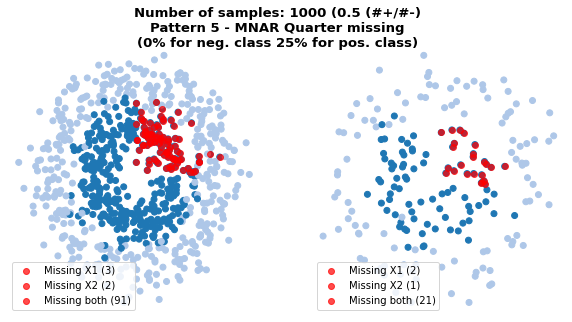

In [15]:
# Dataset default parameters
dataset_name = 'blobs'
num_samples = 1000
imbalance_ratio = IMBALANCE_RATIO

# Missingness default parameters
missingness_pattern = MISSINGNESS_PATTERN
ratio_of_missing_values = RATIO_OF_MISSING_VALUES
ratio_missing_per_class = [0, 0.25]

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH
missingness_pattern = 5

# Classification default parameters
proportion_train = PROPORTION_TRAIN

verbosity=0


dataset_name = 'circles'
approach = 'ebm'
missing_data_handling='encoding'
imputation_method='without'

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            debug=False, 
                            verbosity=verbosity)
dataset.split_test_train()

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, 
                                     ratio_of_missing_values=ratio_of_missing_values, 
                                     ratio_missing_per_class=ratio_missing_per_class)
dataset.plot()
plt.show()

In [21]:
# Create the experiments
exp = Experiments('blobs', 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = 'DecisionTree', 
                  previous_experiment=None, 
                  use_missing_indicator_variables=False,
                  save_experiment=False, 
                  verbosity=4, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)

exp.fit()
exp.predict()
exp.performances_df

,Accuracy,F1 score (2 PPVxTPR/(PPV+TPR)),Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.81,0.821,0.651,0.946,0.694,0.725,0.938,0.054,0.275,0.062


In [ ]:
df_datasets = pd.DataFrame(columns = ['dataset_name','experiment_number', 'missing_data_handling','imputation_method', 
                                'num_samples', 'imbalance_ratio', 'missingness_pattern', 
                                'ratio_of_missing_values', 'ratio_missing_per_class_0', 'ratio_missing_per_class_1'])

range_dataset_name = ['blobs', 'circles', 'moons']
range_ratio_of_missing_values = [0., 0.1, 0.2, 0.3]
range_ratio_missing_per_class = [[0,0.25], [0.1, 0.3]]
range_imbalance_ratio = [0.5, 0.25, 0.1]
range_missingness_pattern = [1, 3, 4, 5]

range_missing_data_handling = ['encoding','imputation']
range_imputation_method = ['mice', 'knn', 'mean', 'multi_dimensional_weighting']


"""  Fix parameters """
#Dataset default parameters
num_samples = 10000

# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN

# Verbosity
verbosity=0



save=True

missingness_dictionnary = {1: (range_ratio_of_missing_values, len(range_ratio_of_missing_values)*[None]),
                           2: (range_ratio_of_missing_values, len(range_ratio_of_missing_values)*[None]),
                           3: (range_ratio_of_missing_values, len(range_ratio_of_missing_values)*[None]),
                           4: (len(range_ratio_missing_per_class)*[None], range_ratio_missing_per_class),
                           5: (len(range_ratio_missing_per_class)*[None], range_ratio_missing_per_class)}


for missing_data_handling in range_missing_data_handling:
    
    for imputation_method in range_imputation_method:

        for dataset_name in range_dataset_name:

            for imbalance_ratio in range_imbalance_ratio:

                for missingness_pattern, (ratio_of_missing_values_list, ratio_missing_per_class_list) in missingness_dictionnary.items():

                    for ratio_of_missing_values, ratio_missing_per_class in zip(ratio_of_missing_values_list, ratio_missing_per_class_list):

                    


                        dataset = DatasetGenerator(dataset_name=dataset_name, 
                                            num_samples=num_samples, 
                                            imbalance_ratio=imbalance_ratio, 
                                            missing_data_handling=missing_data_handling,
                                            imputation_method=imputation_method,
                                            verbosity=verbosity)
                        
                        # Creation of the missingness
                        dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, 
                                                             ratio_of_missing_values=ratio_of_missing_values, 
                                                             ratio_missing_per_class=ratio_missing_per_class)   
                        
                        dataset.split_test_train()

                        exp = Experiments('blobs', 
                                          dataset=dataset, 
                                          purpose='classification', 
                                          approach = 'DecisionTree', 
                                          previous_experiment=None, 
                                          use_missing_indicator_variables=False,
                                          save_experiment=True, 
                                          verbosity=4, 
                                          debug=False, 
                                          proportion_train=PROPORTION_TRAIN, 
                                          resolution=RESOLUTION, 
                                          bandwidth=BANDWIDTH,
                                          random_state=RANDOM_STATE)
                        exp.save()
                        
                        
                        # append rows to an empty DataFrame
                        df_datasets = df_datasets.append({'dataset_name' : dataset_name, 
                                                            'experiment_number' : exp.experiment_number,  
                                                            'missing_data_handling' : missing_data_handling,  
                                                            'imputation_method' : imputation_method,  
                                                            'num_samples' : num_samples,  
                                                            'imbalance_ratio' : imbalance_ratio,  
                                                            'missingness_pattern' : missingness_pattern,  
                                                            'ratio_of_missing_values' : ratio_of_missing_values,  
                                                            'ratio_missing_per_class_0' : ratio_missing_per_class[0] if ratio_missing_per_class is not None else None,
                                                            'ratio_missing_per_class_1' : ratio_missing_per_class[1] if ratio_missing_per_class is not None else None,
                                                            }, 
                                                            ignore_index = True)
                        
                        
                        dataset.plot()
                        plt.show()
                        display(df_datasets)


In [35]:
del dataset

In [36]:


exp = Experiments('blobs', 
                  dataset=None, 
                  purpose='classification', 
                  approach = 'DecisionTree', 
                  previous_experiment=602, 
                  use_missing_indicator_variables=False,
                  save_experiment=True, 
                  verbosity=4, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=RESOLUTION, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


Loaded experiment at '/home01/sam/notes_on_stats/doc/src/data/experiments_29_june_duke/blobs/602/experiment_log.json'
Loaded dataset at '/home01/sam/notes_on_stats/doc/src/data/experiments_29_june_duke/blobs/602/dataset_log.json'
/!\ No previous computed distribution found at '/home01/sam/notes_on_stats/doc/src/data/experiments_29_june_duke/blobs/602/distributions_None_log.json'
/!\ No previous computed distribution found at '/home01/sam/notes_on_stats/doc/src/data/experiments_29_june_duke/blobs/602/distributions_1_log.json'
/!\ No previous computed distribution found at '/home01/sam/notes_on_stats/doc/src/data/experiments_29_june_duke/blobs/602/distributions_0_log.json'
Experiment 602 loaded successfully! :-)


In [39]:
exp.dataset()

          Attribute Name                	 type                                    	 Value or first element                                                                                                                                
          -----------------------------------------------------------------------------------------------------------------------------------------------------------------

          dataset_name                  	 str                                     	 blobs                                                                                                                                                 
          num_samples                   	 int                                     	 5000                                                                                                                                                  
          class_used                    	 None                                    	 None                                  

In [ ]:
    fig, axes = plt.subplots(1, 4, figsize=(25, 8));axes = axes.flatten()
    fig.suptitle("Description of the 5 missingness patterns studied", y=1.05, fontsize=18, weight='bold')

    for i, missingness_pattern in enumerate([1, 3, 4, 5]):

        # Creation of the missingness
        dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern)
        axes[i], _  = dataset.plot(ax1=axes[i], ax2=None)
        axes[i].set_title(DICT_MISSINGNESS[missingness_pattern], weight='bold')
    [axes[i].axis('off') for i in range(len(axes))]; plt.tight_layout()
    
    

In [13]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(random_state=0)

model.fit(dataset.X_train, dataset.y_train)
model.predict_proba(dataset.X_test)



array([[0.47034622, 0.52965378],
       [0.5045004 , 0.4954996 ],
       [0.47585827, 0.52414173],
       [0.52371222, 0.47628778],
       [0.49892426, 0.50107574],
       [0.50523889, 0.49476111],
       [0.49362039, 0.50637961],
       [0.53036865, 0.46963135],
       [0.48329159, 0.51670841],
       [0.49058542, 0.50941458],
       [0.49586953, 0.50413047],
       [0.47891584, 0.52108416],
       [0.52673735, 0.47326265],
       [0.49731647, 0.50268353],
       [0.47525553, 0.52474447],
       [0.51425648, 0.48574352],
       [0.49702349, 0.50297651],
       [0.4806658 , 0.5193342 ],
       [0.51187325, 0.48812675],
       [0.47186804, 0.52813196],
       [0.50513976, 0.49486024],
       [0.46445604, 0.53554396],
       [0.49412852, 0.50587148],
       [0.50782427, 0.49217573],
       [0.4599522 , 0.5400478 ],
       [0.46698379, 0.53301621],
       [0.43750235, 0.56249765],
       [0.50208606, 0.49791394],
       [0.47550057, 0.52449943],
       [0.45666796, 0.54333204],
       [0.

In [12]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini',
                                splitter='best',
                                max_depth=3,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features=None,
                                random_state=None,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                class_weight=None,
                                presort='deprecated',
                                ccp_alpha=0.0)
model = model.fit(dataset.X_train, dataset.y_train)

proba = model.predict_proba(dataset.X_test)
proba

array([[0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.95121951, 0.04878049],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.95652174, 0.04347826],
       [0.95652174, 0.04347826],
       [0.95121951, 0.04878049],
       [0.95652174, 0.04347826],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.81818182, 0.18181818],
       [0.18025751, 0.81974249],
       [0.95652174, 0.04347826],
       [0.18025751, 0.81974249],
       [0.5625    , 0.4375    ],
       [1.        , 0.        ],
       [0.95652174, 0.04347826],
       [1.        , 0.        ],
       [0.18025751, 0.81974249],
       [0.18025751, 0.81974249],
       [0.95652174, 0.04347826],
       [0.